### 导入环境

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader as Dataloader
from modelarts.session import Session

In [2]:
os.getcwd()

'/home/ma-user/work'

In [3]:
os.listdir('../')

['.bash_logout',
 'anaconda3',
 'modelarts-sdk',
 'notebook-exts',
 '.conda',
 '.cache',
 '.jupyter',
 'work',
 'README',
 'env_script',
 '.pip',
 '.bashrc',
 '.profile',
 '.config',
 '.npm',
 '.npmrc',
 '.yarn',
 '.modelarts',
 'docker_custom_env.py',
 'log',
 '.local',
 'notebook-samples-1591414942',
 'notebook-samples',
 '.ipython',
 'test_batch',
 'data_batch1',
 'data_batch2',
 'data_batch3',
 'data_batch4',
 'data_batch5',
 'batches.meta']

### 从OBS上下载数据

In [4]:
import moxing as mox

#下载一个OBS文件夹，从OBS下载至本地Notebook（OBS -> 本地）
mox.file.copy_parallel('obs://bucketzc/AI_hk/test/test_batch', '/home/ma-user/test_batch') # 下载测试数据

for i in range(1,6):
    path = 'obs://bucketzc/AI_hk/train/data_batch_' + str(i)
    mox.file.copy_parallel(path, '/home/ma-user/data_batch'+str(i)) # 下载测试数据

mox.file.copy_parallel('obs://bucketzc/AI_hk/batches.meta', '/home/ma-user/batches.meta') # 下载label对应的物体名

INFO:root:Using MoXing-v1.15.1-92d9ed92
INFO:root:Using OBS-Python-SDK-3.1.2


In [4]:
os.listdir('../')

['.bash_logout',
 'anaconda3',
 'modelarts-sdk',
 'notebook-exts',
 '.conda',
 '.cache',
 '.jupyter',
 'work',
 'README',
 'env_script',
 '.pip',
 '.bashrc',
 '.profile',
 '.config',
 '.npm',
 '.npmrc',
 '.yarn',
 '.modelarts',
 'docker_custom_env.py',
 'log',
 '.local',
 'notebook-samples-1591414942',
 'notebook-samples',
 '.ipython',
 'test_batch',
 'data_batch1',
 'data_batch2',
 'data_batch3',
 'data_batch4',
 'data_batch5',
 'batches.meta']

### 数据存放再字典中，并使用pickle存放到磁盘上，定义unpickle方法，读取数据

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### 定义神经元网络

In [6]:
class vgg19_Net(nn.Module):
    def __init__(self,in_img_rgb=3,in_img_size=64,out_class=1000,in_fc_size=25088):
        super(vgg19_Net,self).__init__()
 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_img_rgb, out_channels=in_img_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_img_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_img_size,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
 
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv14 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv16 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
 
        self.fc17 = nn.Sequential(
            nn.Linear(in_features=in_fc_size, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
 
        self.fc18 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fc19 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=out_class, bias=True)
        )
 
        self.conv_list = [self.conv1,self.conv2,self.conv3,self.conv4,self.conv5,self.conv6,self.conv7,self.conv8,
                          self.conv9,self.conv10,self.conv11,self.conv12,self.conv13,self.conv14,self.conv15,self.conv16]
 
        self.fc_list = [self.fc17,self.fc18,self.fc19]
 
    def forward(self, x):
         
        for conv in self.conv_list:
            x = conv(x)
             
        fc = x.view(x.size(0), -1)
         
        # 查看全连接层的参数：in_fc_size  的值
        # print("vgg19_model_fc:",fc.size(1))
 
        for fc_item in self.fc_list:
            fc = fc_item(fc)
 
        return fc
 

### 创建模型实例

In [7]:
network = vgg19_Net(in_img_rgb=3, in_img_size=32, out_class=10, in_fc_size=512)

### 数据读取和模型训练

##### 使用 Adam 作为优化器和 cross entropy 计算损失

In [8]:
optimizer = optim.Adam(network.parameters(), lr=0.0001)

In [9]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [10]:
def get_correct_num(preds, labels):
    correct = preds.argmax(dim=1).eq(labels).sum().item()
    return correct

In [11]:
torch.set_grad_enabled(True) # 打开对梯度的追踪

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
network.to(device)

vgg19_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [15]:
print(torch.cuda.device_count())

1


In [16]:
tt_correct = 0
epoch = 0



while(tt_correct < 9800): # 定义当网络的准确率在98%时停止训练
    print('epoch',epoch,':')
    for i in range(1,6):
        path = '/home/ma-user/data_batch'+str(i)

        data = unpickle(path) # 读取第一组数据
        print(data[b'batch_label'],' accessed')
        
        
        images = torch.reshape(torch.tensor(data[b'data'], dtype=torch.float), (10000,3,32,32)) # 从字典中拿出图片数据
        labels = torch.tensor(data[b'labels'], dtype=torch.long) # 从字典中拿出label数据
        
        images = images.to(device)
        labels = labels.to(device)

        images_loader = Dataloader(images, batch_size=100) # 图片迭代器
        labels_loader = Dataloader(labels, batch_size=100) # label迭代器
        
        

        # 开始训练模型

        tt_loss = 0
        tt_correct = 0

        for images_batch, labels_batch in zip(images_loader, labels_loader): # 从迭代器中按批取出数据
            #images_batch.cuda()
            #labels_batch.cuda()
            

            preds = network(images_batch).to(device) # 计算预测值
            loss = F.cross_entropy(preds, labels_batch) # 计算误差
            loss.backward() # 误差的前向传播
            optimizer.step() # 更新权重

            tt_correct += get_correct_num(preds, labels_batch)
            tt_loss += loss.item()

            optimizer.zero_grad() # 梯度不累加

        print(data[b'batch_label'],' total_loss:',tt_loss,' acc:',tt_correct/10000)
    epoch +=1

epoch 0 :
b'training batch 1 of 5'  accessed
b'training batch 1 of 5'  total_loss: 181.74766314029694  acc: 0.2949
b'training batch 2 of 5'  accessed
b'training batch 2 of 5'  total_loss: 144.9326342344284  acc: 0.4552
b'training batch 3 of 5'  accessed
b'training batch 3 of 5'  total_loss: 128.06764221191406  acc: 0.5291
b'training batch 4 of 5'  accessed
b'training batch 4 of 5'  total_loss: 119.81898999214172  acc: 0.5752
b'training batch 5 of 5'  accessed
b'training batch 5 of 5'  total_loss: 110.16046166419983  acc: 0.6088
epoch 1 :
b'training batch 1 of 5'  accessed
b'training batch 1 of 5'  total_loss: 102.07843112945557  acc: 0.6412
b'training batch 2 of 5'  accessed
b'training batch 2 of 5'  total_loss: 97.90666604042053  acc: 0.6576
b'training batch 3 of 5'  accessed
b'training batch 3 of 5'  total_loss: 90.03115665912628  acc: 0.6867
b'training batch 4 of 5'  accessed
b'training batch 4 of 5'  total_loss: 88.07578432559967  acc: 0.694
b'training batch 5 of 5'  accessed
b'tra

b'training batch 3 of 5'  total_loss: 8.259934726171196  acc: 0.9738
b'training batch 4 of 5'  accessed
b'training batch 4 of 5'  total_loss: 8.759199583902955  acc: 0.9709
b'training batch 5 of 5'  accessed
b'training batch 5 of 5'  total_loss: 7.238477049395442  acc: 0.9765
epoch 16 :
b'training batch 1 of 5'  accessed
b'training batch 1 of 5'  total_loss: 7.109146150760353  acc: 0.9766
b'training batch 2 of 5'  accessed
b'training batch 2 of 5'  total_loss: 8.868330870755017  acc: 0.9715
b'training batch 3 of 5'  accessed
b'training batch 3 of 5'  total_loss: 7.865737423300743  acc: 0.9774
b'training batch 4 of 5'  accessed
b'training batch 4 of 5'  total_loss: 6.572654112242162  acc: 0.979
b'training batch 5 of 5'  accessed
b'training batch 5 of 5'  total_loss: 7.012289987877011  acc: 0.9773
epoch 17 :
b'training batch 1 of 5'  accessed
b'training batch 1 of 5'  total_loss: 6.2890067412517965  acc: 0.9789
b'training batch 2 of 5'  accessed
b'training batch 2 of 5'  total_loss: 7.42

### 测试模型

In [17]:
test_path = '/home/ma-user/test_batch'

test_data = unpickle(test_path) # 读取第一组数据
print(test_data[b'batch_label'],' accessed')

test_images = torch.reshape(torch.tensor(test_data[b'data'], dtype=torch.float), (10000,3,32,32)) # 从字典中拿出图片数据
test_labels = torch.tensor(test_data[b'labels'], dtype=torch.long) # 从字典中拿出label数据

test_images = test_images.to(device)
test_labels = test_labels.to(device)

test_images_loader = Dataloader(test_images, batch_size=100) # 图片迭代器
test_labels_loader = Dataloader(test_labels, batch_size=100) # label迭代器

size = test_images.size()


tt_loss = 0
tt_correct = 0

for test_images_batch, test_labels_batch in zip(test_images_loader, test_labels_loader): # 从迭代器中按批取出数据
    preds = network(test_images_batch) # 计算预测值
    
    tt_correct += get_correct_num(preds, test_labels_batch)
    tt_loss += loss.item()


print(test_data[b'batch_label'],' total_loss:',tt_loss,' acc',tt_correct/10000)


b'testing batch 1 of 1'  accessed
b'testing batch 1 of 1'  total_loss: 7.3472462594509125  acc 0.7771


In [18]:
details = unpickle('/home/ma-user/batches.meta')

label: b'horse'


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


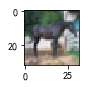

In [21]:
test_image = test_images_batch[45]
test_image.cpu()
test_image = torch.tensor(test_image,dtype=torch.int)
plt.figure(figsize=(1,1))
plt.imshow(np.transpose(test_image, (1,2,0)))
print('label:',details[b'label_names'][test_labels_batch[45]])